In [2]:
import mne
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math
import pandas as pd
import numpy as np
from copy import copy
import os
from collections import OrderedDict

# from jupyterthemes import jtplot
# jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
%matplotlib auto


Using matplotlib backend: QtAgg


In [3]:
filename = r"C:/Users/Admin/Desktop/IMAGERY_EEG/AL_23_08/AL_MI_right hand.vhdr"
SMR_CONDITION = filename.split('/')[-1].split('_')[1]
SUBJECT = filename.split('/')[-1].split('_')[0]

raw = mne.io.read_raw_brainvision(filename,  preload=True, verbose=False)
raw.drop_channels(['ECG', 'breathing',])

try:
    raw.drop_channels(['Cz'])
    print('Cz channel dropped')
except ValueError:
    raw.drop_channels(['tp10_ref'])
    print('tp10_ref channel dropped')

    
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

###PREPROCESSING
# mne.set_eeg_reference(raw, ref_channels='average', verbose=False)
raw.filter(0.1, 30, fir_design='firwin', skip_by_annotation='edge', verbose=False)




### Handling digitaization 
channels = raw.ch_names
montage = mne.channels.make_standard_montage('standard_1005')
montage = montage.get_positions()
ch_pos = montage['ch_pos']
pos_all = np.stack([ch_pos[i][0:2] for i in channels])
pos_origin = np.stack([ch_pos[i] for i in channels])

pos_dict_list = []
for i in ch_pos.items():
    for j in channels:
        if i[0] == j:
            pos_dict_list.append(i)
pos_dict = OrderedDict(pos_dict_list) # an odict with X\Y\Z positions for interpolation needs 


our_dig = mne.channels.make_dig_montage(ch_pos=pos_dict, 
                              hpi=montage['hpi'], 
                              coord_frame=montage['coord_frame'], 
                              hsp=montage['hsp'],
                              nasion=montage['nasion'],
                              lpa=montage['lpa'],
                              rpa=montage['rpa'],
                             )
raw.set_montage(our_dig)



raw.info['bads'] = ['T8', 'P8']
raw.interpolate_bads(reset_bads=True)
print('PREPROCESSING FINISHED')

C:\Users\Admin\AppData\Local\Temp\ipykernel_9572\13889212.py:5: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(filename,  preload=True, verbose=False)


Cz channel dropped
Interpolating bad channels
    Automatic origin fit: head of radius 97.2 mm
Computing interpolation matrix from 19 sensor positions
Interpolating 2 sensors
PREPROCESSING FINISHED


Using matplotlib as 2D backend.


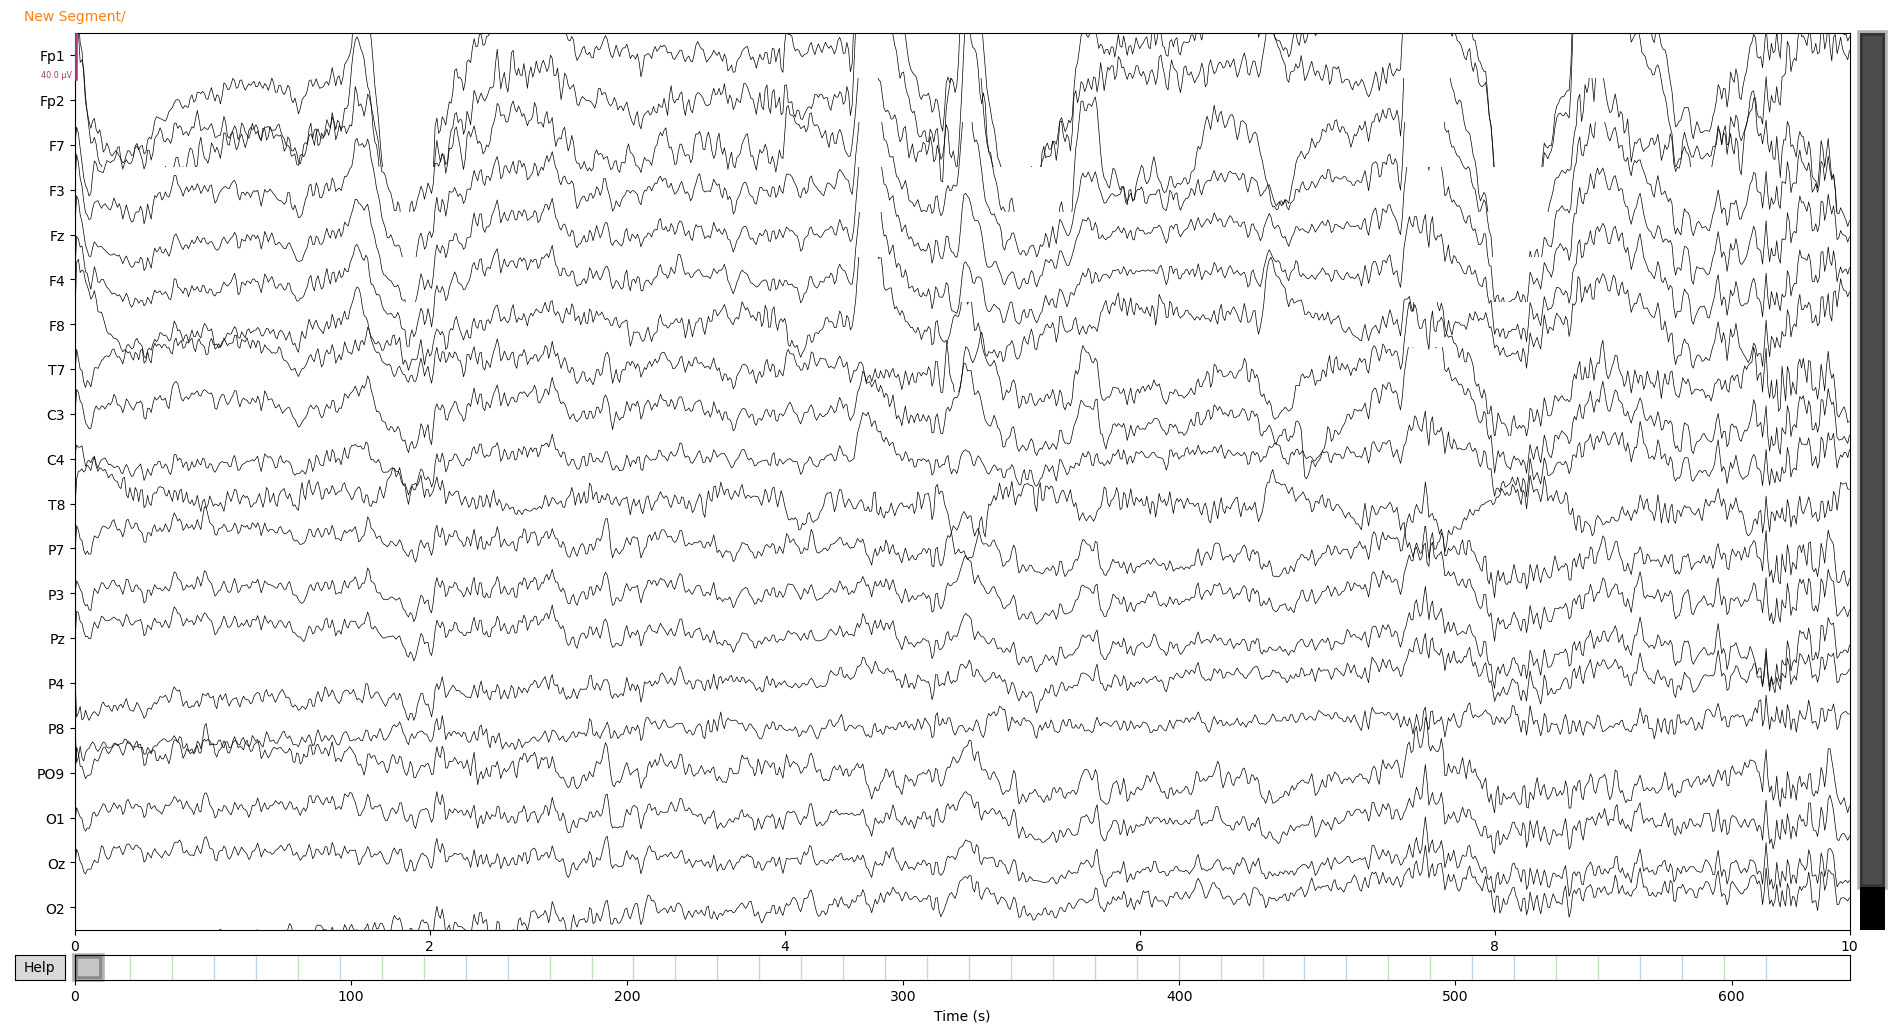

Channels marked as bad:
none


In [4]:
# raw.info.ch_names.index('C3')
# %matplotlib auto
raw.plot()


In [28]:
index_fmin = list(ffreqs).index(float(fmin))
index_fmax = list(ffreqs).index(float(fmax))
freq_window = data[index_fmin:index_fmax]
center = np.max(freq_window)
center_index = list(data).index(float(center))
peak_freq = ffreqs[center_index]


if round_freq:
    peak_freq = np.round(peak_freq)
    lower_freq_border = peak_freq - area_around_peak
    upper_freq_border = peak_freq + area_around_peak
    return lower_freq_border, upper_freq_border, peak_freq
else:
    peak_freq = np.round(peak_freq)
    lower_freq_border = peak_freq - area_around_peak
    upper_freq_border = peak_freq + area_around_peak
    return lower_freq_border, upper_freq_border, peak_freq

ValueError: 30.0 is not in list

In [13]:
events, ids = mne.events_from_annotations(raw)
events_to_exclude = [99999, 12]
events = mne.pick_events(events, exclude=events_to_exclude)


def removekey(d, key):
    r = dict(d)
    del r[key]
    return r
try:
    ids = removekey(ids, 'New Segment/')
except KeyError:
    pass

try:
    ids = removekey(ids, 'Stimulus/S 12')
except KeyError:
    pass

try:
    ids = removekey(ids, 'Response/R  2')
except KeyError:
    pass

try:
    ids['SMR'] = ids.pop('Motor/M  1')
    ids['rest'] = ids.pop('Rest/R  1')
except:
    pass

# raw.plot(block=True)
 
# raw.plot(block=True, events = events,  event_id=ids)
# original_bads = ['T8', 'FT10', 'FT8', 'P10', 'TPP10h', 'TTP8h', 'FTT10h']
# raw.info['bads'] = original_bads 
# raw.interpolate_bads( reset_bads=True, method=dict(eeg='MNE'), verbose=False)

###EPOCHS
tmin, tmax = -2.0, 4.0
fmin, fmax = 5, 30
baseline=(tmin, 0)

epochs = mne.Epochs(
                    raw, 
                    events, 
                    event_id=ids,
                    tmin=tmin, 
                    tmax=tmax, 
                    baseline=baseline, 
                    preload=True
                    )     

###FULL SPECTRUM CALCULATION

#number of subfrequencies in our spectrum is defined by freq limits and the length of one epoch
ffreqs = np.arange(fmin, fmax, 1/np.abs(tmin-tmax))
ffreqs = np.round(ffreqs, decimals=3)

rst_full = mne.time_frequency.EpochsSpectrum(epochs['rest'], 
                                                     method='multitaper', 
                                                     fmin=fmin, 
                                                     fmax=fmax, 
                                                     tmin=tmin,
                                                     tmax=tmax,
                                                     picks='all',
                                                     proj=None,
                                                     normalization='full',
                                                     n_jobs=-1
                                                    )
smr_full = mne.time_frequency.EpochsSpectrum(epochs['SMR'], 
                                                    method='multitaper', 
                                                    fmin=fmin, 
                                                    fmax=fmax,
                                                    tmin=tmin,
                                                    tmax=tmax,
                                                    picks='all',
                                                    proj=None,
                                                    normalization='full',
                                                    n_jobs=-1
                                                   )

# rst_full = 10 * np.log10(rst_full.get_data())  # convert to dB
# smr_full = 10 * np.log10(smr_full.get_data())

rst_full = rst_full.get_data().mean(0)[raw.info.ch_names.index('C3')]
smr_full = smr_full.get_data().mean(0)[raw.info.ch_names.index('C3')]

diff = rst_full - smr_full


# y_rest = rst_full.mean(0)[raw.info.ch_names.index('C3')]
# y_smr = smr_full.mean(0)[raw.info.ch_names.index('C3')]


# diff =  y_rest - y_smr



def detect_freq_peak(data, ffreqs, fmin, fmax, area_around_peak=1.0, round_freq=True):
    index_fmin = list(ffreqs).index((fmin))
    index_fmax = list(ffreqs).index((fmax))
    freq_window = data[index_fmin:index_fmax]
    center = np.max(freq_window)
    center_index = list(data).index((center))
    peak_freq = ffreqs[center_index]

    
    if round_freq:
        peak_freq = np.round(peak_freq)
        lower_freq_border = peak_freq - area_around_peak
        upper_freq_border = peak_freq + area_around_peak
        return lower_freq_border, upper_freq_border, peak_freq
    else:
        peak_freq = np.round(peak_freq)
        lower_freq_border = peak_freq - area_around_peak
        upper_freq_border = peak_freq + area_around_peak
        return lower_freq_border, upper_freq_border, peak_freq
    
lower_beta, upper_beta, center_beta = detect_freq_peak(data=diff, ffreqs=ffreqs, fmin=15, fmax=29, area_around_peak=1, )
lower_mu, upper_mu, center_mu = detect_freq_peak(data=diff, ffreqs=ffreqs, fmin=8, fmax=14, area_around_peak=1)
                                                                 

###FULL SPECTRUM VIZUALIZATION
sns.lineplot(x=ffreqs, y=rst_full, color='black', label="Rest", linewidth=1.25)
sns.lineplot(x=ffreqs, y=smr_full, color='red', label=f'{SMR_CONDITION}', linewidth=1.25)
sns.lineplot(x=ffreqs, y=diff, color='blue', label=f'diff', linewidth=1.25)

# sns.lineplot(x=ffreqs, y=diff,color='darkblue', label="Delta", linewidth=1.25)

beta_vlines_kwargs = dict(ymin=min(rst_full), ymax=max(smr_full), linestyles='dashed', color='green')
plt.vlines(x=upper_beta, **beta_vlines_kwargs)
plt.vlines(x=lower_beta,  **beta_vlines_kwargs)
plt.vlines(x=center_beta,  **beta_vlines_kwargs)

mu_vlines_kwargs = dict(ymin=min(rst_full), ymax=max(smr_full), linestyles='dotted', color='green')
plt.vlines(x=upper_mu, **mu_vlines_kwargs)
plt.vlines(x=lower_mu,  **mu_vlines_kwargs)
plt.vlines(x=center_mu,  **mu_vlines_kwargs)
plt.hlines(y=0, xmin=0, xmax=29)



Used Annotations descriptions: ['Motor/M  1', 'New Segment/', 'Rest/R  1']
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 3001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


In [8]:
### PSD CALCULATION FOR TOPOMAPS

def psd_for_topo(epochs=epochs,
                 epoch_rest='rest',
                 epochs_target='SMR',
                 method='welch',
                 fmin=9, 
                 fmax=13, 
                 tmin=tmin, 
                 tmax=tmax, 
                 picks='all',
                 proj=None,
                 n_fft=1000, 
                 n_overlap=800,
                 n_jobs=-1,
                 mode='dB'
                ):

    rest = epochs[epoch_rest].compute_psd(
                                method=method, 
                                fmin=8.5, 
                                fmax=10.0,
                                tmin=tmin,
                                tmax=tmax,
                                picks=picks,
                                proj=proj,
                                n_jobs=-n_jobs,
                                n_fft=n_fft, 
                                n_overlap=n_overlap
                                )

    target = epochs[epochs_target].compute_psd(
                                method=method, 
                                fmin=fmin, 
                                fmax=fmax,
                                tmin=tmin,
                                tmax=tmax,
                                picks=picks,
                                proj=proj,
                                n_jobs=n_jobs,
                                n_fft=n_fft, 
                                n_overlap=n_overlap
                                )

    rest_median= np.median(rest.get_data().mean(2), axis=0)
    target_median = np.median(target.get_data().mean(2), axis=0)
    if mode=='dB':
        erd_dB = pd.DataFrame(data=10*np.log10(rest_median/target_median), index=raw.ch_names)[0]
        return erd_dB
        
    if mode=='percent':
        erd_percent = pd.DataFrame(data=(rest_median-target_median)/rest_median*100, index=raw.ch_names)[0]
        return erd_percent
    
erd_mu = psd_for_topo(fmin=lower_mu, fmax=upper_mu)
erd_beta = psd_for_topo(fmin=lower_beta, fmax=upper_beta)

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Effective window size : 2.000 (s)


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    4.7s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.7s finished


Effective window size : 2.000 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), squeeze=False)
mne.viz.plot_topomap(erd_mu, pos=raw.info, names=channels, axes=axes[0, 0], )
mne.viz.plot_topomap(erd_beta, pos=raw.info, names=channels, axes=axes[0, 1])
axes[0, 0].set_title(f'Mu ERD/S in {SMR_CONDITION}. Freqs:{lower_mu}-{upper_mu}\nSubject : {SUBJECT}')
axes[0, 1].set_title(f'Beta ERD/S in {SMR_CONDITION}. Freqs:{lower_beta}-{upper_beta}\nSubject : {SUBJECT}')


Text(0.5, 1.0, 'Beta ERD/S in MI. Freqs:25.0-27.0\nSubject : AL')

In [156]:
fig2, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,5), squeeze=False)
ax = axes[0]
fig2 = mne.viz.plot_topomap(erd_dB, raw.info, names=channels)
ax[0].set_title('ERD in dB. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')

pic_name = 0

custom_name = None
# custom_name = 'AM_TI_0_narrow_12-14_HZ'
if custom_name:
    
    pic_name = [custom_name, '_dB', '.png']
else:
    pic_name = [filename[0:20], '_dB', '.png']

pic_name = ''.join(pic_name)
# plt.savefig(pic_name)

RuntimeError: No digitization points found.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\Admin\AppData\Local\Temp\ipykernel_12260\1888818663.py:9: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs['rest'].plot_psd(fmax=30)


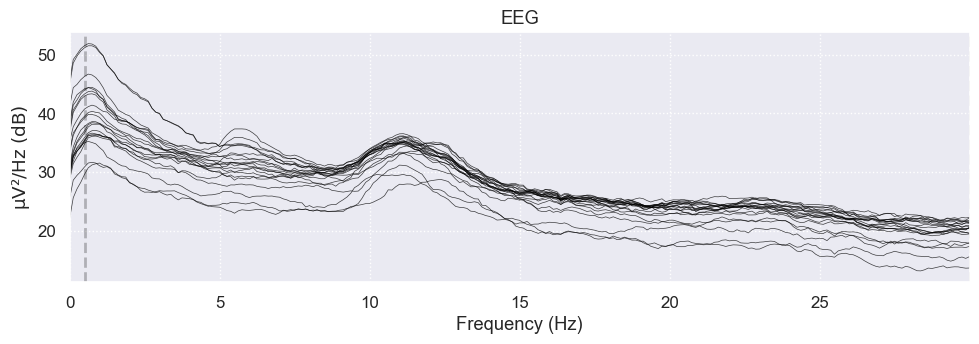

In [93]:
# chanels = pd.DataFrame(raw.info.ch_names)
# chanels.head(50)
#bads_eliminated.plot()
#bads_eliminated.plot_sensors()
# epochs.plot(block=True)
# #print(raw.info['bads'])
# #bads_eliminated.plot_psd(fmax=30)
# #epochs.interpolate_bads( reset_bads=True, method=dict(eeg='MNE'), verbose=True)
epochs['rest'].plot_psd(fmax=30)
# epochs['vibro'].plot_psd(fmax=30)


In [12]:
%matplotlib auto
raw.plot(block=True)
#raw.interpolate_bads( reset_bads=True, method=dict(eeg='MNE'), verbose=True)
#bads_eliminated.plot_psd(fmax=30)
picks = mne.pick_channels_regexp(raw.ch_names, regexp='T.|P.')


Using matplotlib backend: Qt5Agg
Channels marked as bad: none


In [67]:
vibro_epochs

<Epochs |  19 events (all good), 0 - 6 sec, baseline 0 – 0 sec, ~110.7 MB, data loaded,
 'vibro': 19>

In [77]:
vibro_epochs = epochs['vibro']
rest_epochs = epochs['rest']


# vibro_epochs.plot_image(picks=['C3'])

frequencies = np.linspace(5,35,100)
n_cycles = frequencies  # different number of cycle per frequency
vibro_epochs_4power = vibro_epochs.copy().pick_channels(['CP2', 'CP4', "C2", "C4"])
power = mne.time_frequency.tfr_morlet(vibro_epochs_4power, freqs=frequencies, n_cycles=n_cycles, use_fft=False,
                        return_itc=0, decim=1, n_jobs=1)
power.apply_baseline([5,6], mode='logratio',)
left_hand_electrodes = ['CP2', 'CP4', "C2", "C4"]
right_hand_electrodes = ['CP3', 'CP5', "C3", "C5"]

if "_l" or "_L" in filename:
    
#     _, axis = plt.subplots(2, 2)
    
#     fig1 = power.plot(left_hand_electrodes[0])
#     axis[0, 0].set_title(left_hand_electrodes[0])
#     plt.subplot(211)


#     fig2 = power.plot(left_hand_electrodes[1])
#     axis[1, 1].set_title(left_hand_electrodes[1])
#     plt.subplot(212)

    
#     fig3 = power.subplot(left_hand_electrodes[2])
#     axis[1, 0].set_title(left_hand_electrodes[2])
#     plt.subplot(223)

    
#     fig4 = power.plot(left_hand_electrodes[3])
#     axis[0, 1].set_title(left_hand_electrodes[3])
#     plt.subplot(224)

#     # Combine all the operations and display
#     plt.show()
    
    

    power.plot(picks=left_hand_electrodes[0])
    power.plot(picks=left_hand_electrodes[1])
    power.plot(picks=left_hand_electrodes[2])
    power.plot(picks=left_hand_electrodes[3])
    


    plt.show()

else:
    pass
#     power.plot(['CP3', 'CP5', "C3", "C5"])


Applying baseline correction (mode: logratio)
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


In [ ]:
power

In [66]:
power.plot(picks=left_hand_electrodes[0])

No baseline correction applied


[<Figure size 640x480 with 2 Axes>]

Using matplotlib backend: Qt5Agg


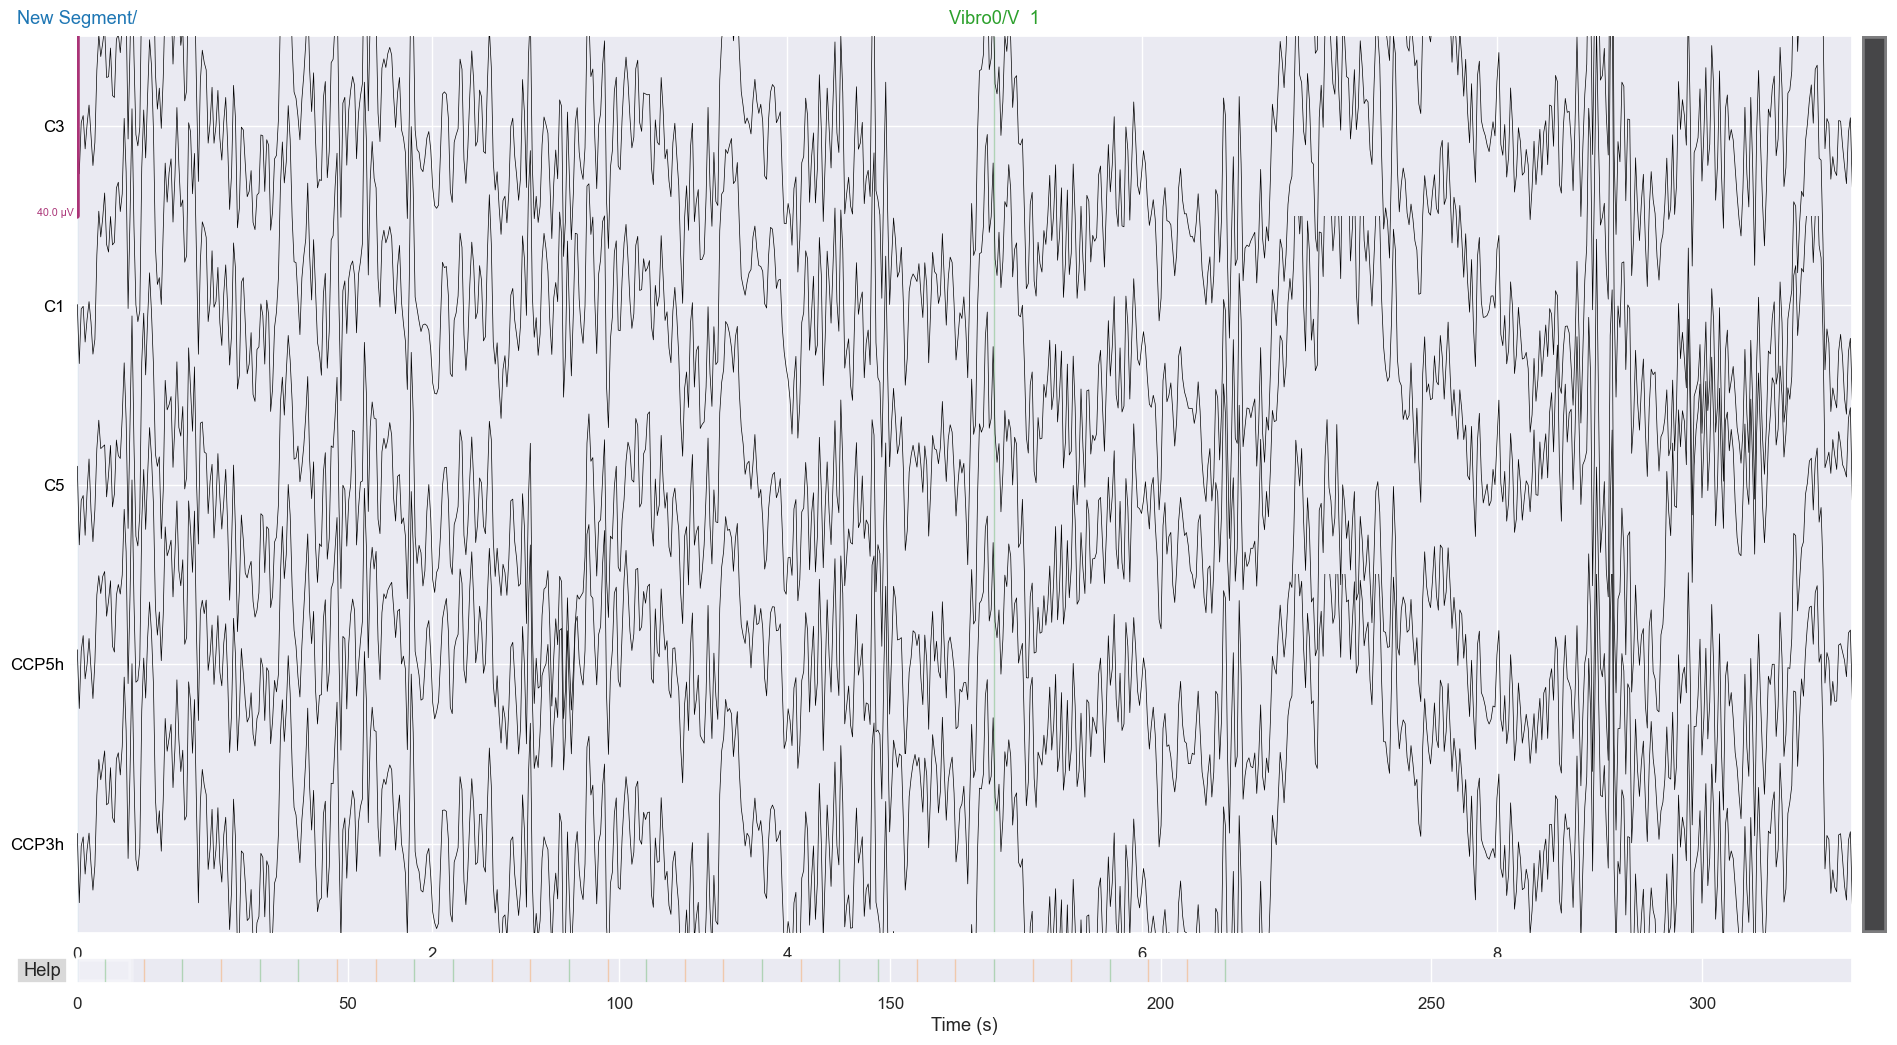

In [42]:
%matplotlib auto

picks = mne.pick_channels(raw.ch_names, ['C3', 'C5', 'C1', 'CCP5h', 'CCP3h'])

raw.plot(order=picks, n_channels=len(picks))



Dropped 0 epochs: 
Channels marked as bad: none


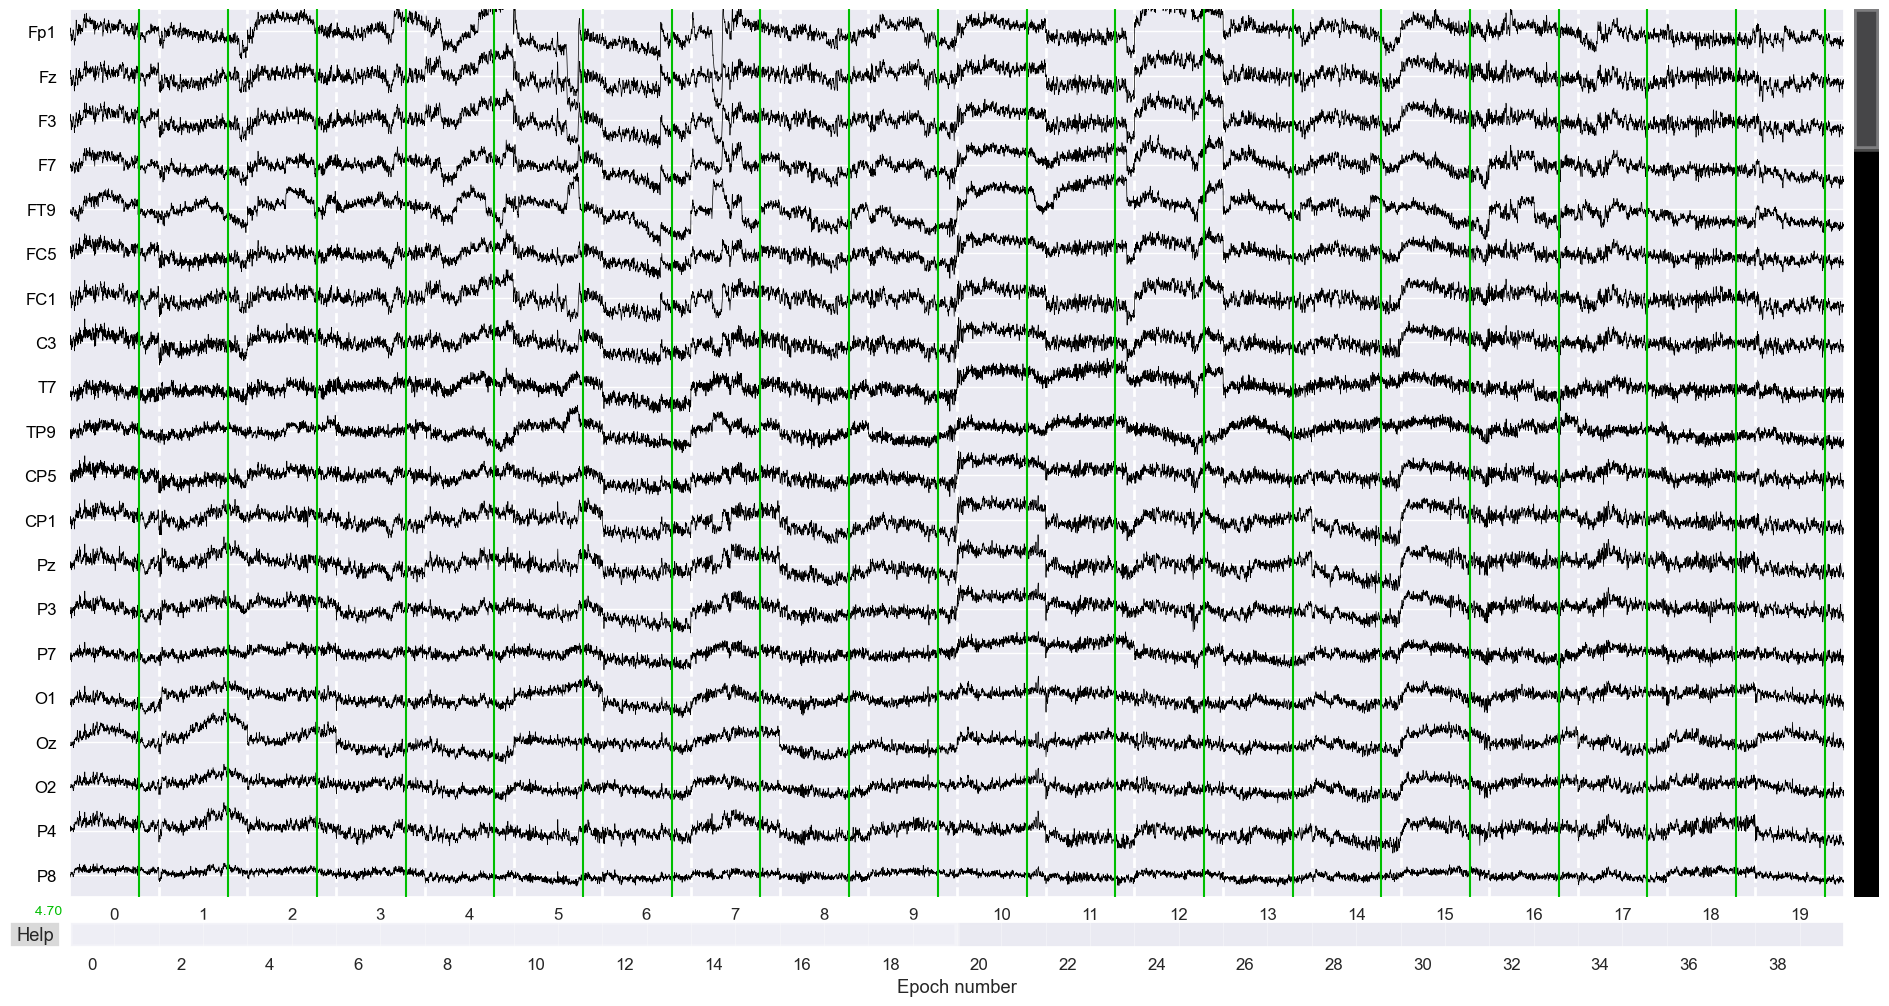

In [44]:
epochs.plot(block=True)


In [107]:
fig = mne.viz.plot_topomap(erd_percents, raw.info)
fig.set_title('Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz', fontweight='bold')

AttributeError: 'tuple' object has no attribute 'set_title'

In [115]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
mne.viz.plot_topomap(erd_percents, raw.info, axes=ax[0], show=False)
mne.viz.plot_topomap(erd_dB, raw.info, axes=ax[1], show=False)
ax[0].set_title('ERD percentage. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')
ax[1].set_title('ERD in dB. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')


Text(0.5, 1.0, 'ERD in dB. Frequency range:7-14Hz')

In [128]:
fig = mne.viz.plot_topomap(erd_percents, raw.info, show=False)
set_title('ERD percentage. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')

AttributeError: module 'mne' has no attribute 'plot_topomap'

In [132]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,3), squeeze=False)

ax = axes[0]
fig = mne.viz.plot_topomap(erd_percents, raw.info)
ax[0].set_title('ERD percentage. Frequency range:' + str(minimal_freq) + '-' + str(maximal_freq) + 'Hz')
# ax = axes[0]
# mne.viz.topomap.plot_topomap(temp,l.pos,axis=ax)

Text(0.5, 1.0, 'ERD percentage. Frequency range:7-14Hz')

In [3]:
df = pd.read_csv(r'C:\Users\Admin\Desktop\freq ranges.txt')
print(df['min'].median(), df['max'].median())
print(df['min'].mean(), df['max'].mean())


10.25 11.25
10.45 11.55


In [6]:
filename = r'C:\Users\Admin\Desktop\MANY PIPELINES\eeg_brainvision\EMP01.vhdr'
raw = mne.io.read_raw_brainvision(filename,  preload=True)
mne.set_eeg_reference(raw)
raw.filter(0.1, 30, fir_design='firwin', skip_by_annotation='edge')
events, ids = mne.events_from_annotations(raw)

Extracting parameters from C:\Users\Admin\Desktop\MANY PIPELINES\eeg_brainvision\EMP01.vhdr...
Setting channel info structure...
Reading 0 ... 2541055  =      0.000 ...  4962.998 secs...


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 sec)

Used Annotations descriptions: ['New Segment/', 'Stimulus/1030', 'Stimulus/1031', 'Stimulus/1039', 'Stimulus/1040', 'Stimulus/1041', 'Stimulus/1049', 'Stimulus/1110', 'Stimulus/1111', 'Stimulus/1119', 'Stimulus/1120', 'Stimulus/1121', 'Stimulus/1129', 'Stimulus/2030', 'Stimulus/2031', 'Stimulus/2039', 'Stimulus/2040', 'S

In [16]:
ids

{'New Segment/': 99999,
 'Stimulus/1030': 10001,
 'Stimulus/1031': 10002,
 'Stimulus/1039': 10003,
 'Stimulus/1040': 10004,
 'Stimulus/1041': 10005,
 'Stimulus/1049': 10006,
 'Stimulus/1110': 10007,
 'Stimulus/1111': 10008,
 'Stimulus/1119': 10009,
 'Stimulus/1120': 10010,
 'Stimulus/1121': 10011,
 'Stimulus/1129': 10012,
 'Stimulus/2030': 10013,
 'Stimulus/2031': 10014,
 'Stimulus/2039': 10015,
 'Stimulus/2040': 10016,
 'Stimulus/2041': 10017,
 'Stimulus/2049': 10018,
 'Stimulus/2091': 10019,
 'Stimulus/2110': 10020,
 'Stimulus/2111': 10021,
 'Stimulus/2119': 10022,
 'Stimulus/2120': 10023,
 'Stimulus/2121': 10024,
 'Stimulus/2129': 10025,
 'Time 0/': 10026}

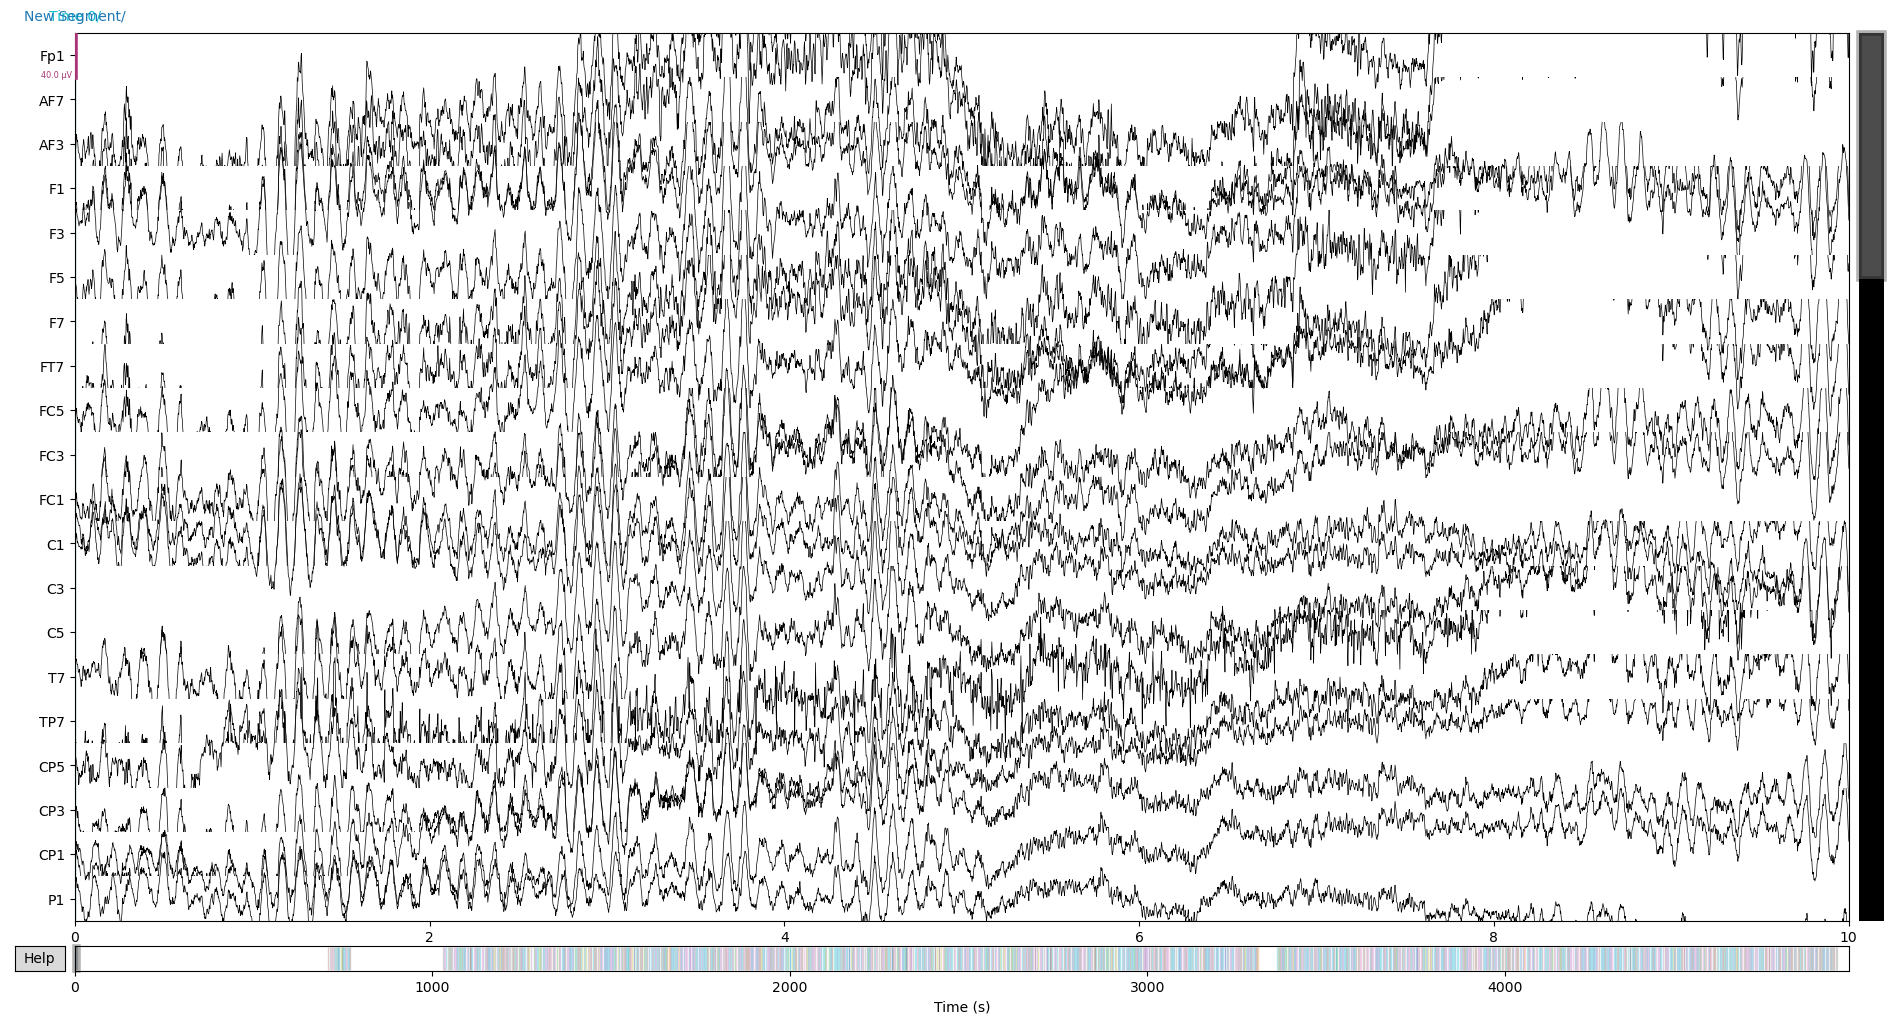

Channels marked as bad: none


In [12]:
raw.plot()

<ipython-input-21-c5fc4a38815d>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events)


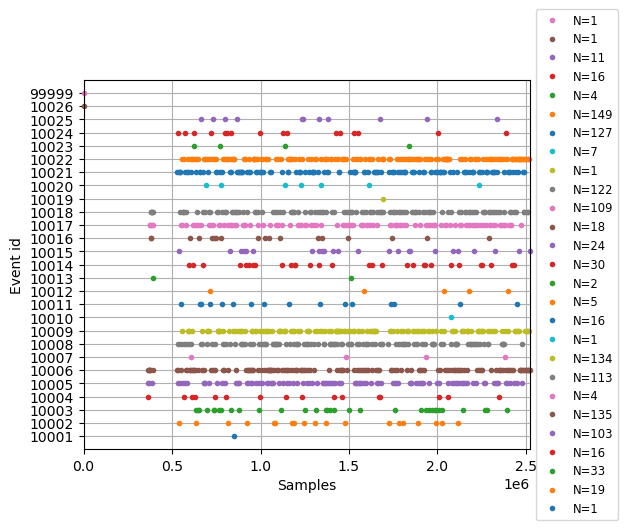

In [21]:
mne.viz.plot_events(events)

In [ ]:
mne.samples.fetch_fsaverage([subjects_dir, verbose])